## Overview
### Two Tower Architecture
This model is based on the two-tower architecture
The two towers are used to learn representations of both the user and the item. The two-tower model is based on queries and the candidate they both shared a low-dimensional vector space. In our case, a query is customer and its transactions features and the candidate is the articles.

I will try to use mlflow to keep track of experiments (and improve myself with this tool).



![Alt text](https://miro.medium.com/v2/resize:fit:420/1*JbK2gjfLC4IFoM6AVWLaUQ.png)

![Alt text](https://miro.medium.com/v2/resize:fit:420/format:webp/0*aJHT3_bGIvERfhaY)

[image source](https://medium.com/smartnews-inc/user-behavior-sequence-for-items-recommendation-in-smartnews-ads-2376622f6192)



Source: 
- https://medium.com/smartnews-inc/user-behavior-sequence-for-items-recommendation-in-smartnews-ads-2376622f6192
- https://cloud.google.com/blog/products/ai-machine-learning/scaling-deep-retrieval-tensorflow-two-towers-architecture?hl=en

In [2]:
import pandas as pd
import numpy as np
import preprocessing
import torch

## Reading data and feature selections

In [3]:
articles_df = pd.read_csv("data/articles.csv", encoding="utf-8")
print("Shape before: ", articles_df.shape)
articles_df = preprocessing.preprocess_articles(articles_df)
print("Shape after: ", articles_df.shape)

Shape before:  (105542, 25)
Shape after:  (105542, 24)


In [4]:
customers_df = pd.read_csv("data/customers.csv", encoding="utf-8")
print("Shape before: ", customers_df.shape)
customers_df = preprocessing.preprocess_customers(customers_df)
print("Shape after: ", customers_df.shape)

Shape before:  (1371980, 7)
Shape after:  (1356119, 5)


In [5]:
transaction_df = pd.read_csv("data/transactions_train.csv", encoding="utf-8")
print("Shape before: ", transaction_df.shape)
transaction_df = preprocessing.preprocess_transactions(transaction_df)
print("Shape after: ", transaction_df.shape)

Shape before:  (31788324, 5)
Shape after:  (31788324, 11)


In [6]:
# join the three data sources to make the data compatible with out retrieval model.
df = pd.merge(
    pd.merge(
        transaction_df[["article_id", "customer_id", "t_dat", "price", "month_sin", "month_cos"]], articles_df[["article_id", "garment_group_name", "index_group_name"]], on="article_id", how="inner"
    ),
    customers_df[["customer_id", "age", "club_member_status", "age_group"]],
    on="customer_id",
    how="inner",
)

In [7]:
df.head(2)

,article_id,customer_id,t_dat,price,month_sin,month_cos,garment_group_name,index_group_name,age,club_member_status,age_group
0,663713001,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,-0.866025,-0.5,"Under-, Nightwear",Ladieswear,24.0,ACTIVE,19-25
1,663713001,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-24,0.050831,-0.866025,-0.5,"Under-, Nightwear",Ladieswear,24.0,ACTIVE,19-25


In [8]:
df.shape

(31648066, 11)

## Train/Validate/Test split and Tensors

In [9]:
from sklearn.model_selection import train_test_split

seed = 2024
torch.manual_seed(seed)

In [10]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=seed)

In [11]:
train_df.isnull().sum()

article_id            0
customer_id           0
t_dat                 0
price                 0
month_sin             0
month_cos             0
garment_group_name    0
index_group_name      0
age                   0
club_member_status    0
age_group             0
dtype: int64

In [12]:
print("Training shape: ", train_df.shape)
print("Validation shape: ", val_df.shape)

Training shape:  (28483259, 11)
Validation shape:  (3164807, 11)


In [13]:
# from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import LabelEncoder


# class CachedDataset(Dataset):
#     def __init__(self, df):
#         self.encoders = {}
#         self.data = {}

#         # Process each column based on its type
#         for col in df.columns:
#             # Get column data
#             col_data = df[col].values

#             # Handle different data types
#             if pd.api.types.is_numeric_dtype(df[col]) or col in ["article_id"]:
#                 # For numeric data, convert to float32
#                 self.data[col] = torch.tensor(col_data.astype(np.float32))

#             else:
#                 print("Col: ", col)
#                 # For categorical/string data, use label encoding
#                 self.encoders[col] = LabelEncoder()
#                 encoded_data = self.encoders[col].fit_transform(col_data)
#                 self.data[col] = torch.tensor(encoded_data, dtype=torch.long)

#     def __len__(self):
#         return len(next(iter(self.data.values())))

#     def __getitem__(self, idx):
#         return {key: value[idx] for key, value in self.data.items()}

#     def get_feature_dims(self):
#         """Return the number of unique values for each categorical feature"""
#         feature_dims = {}
#         for col, encoder in self.encoders.items():
#             feature_dims[col] = len(encoder.classes_)
#         return feature_dims

In [14]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, df):
        self.data = {col: torch.tensor(df[col].values) if pd.api.types.is_numeric_dtype(df[col]) else df[col].values for col in df.columns}

    def __len__(self):
        return len(next(iter(self.data.values())))

    def __getitem__(self, idx):
        return {key: value[idx] for key, value in self.data.items()}

In [15]:
def custom_collate_fn(batch):
    """
    Custom collate function to handle mixed-type datasets

    Args:
        batch (list): List of dictionaries from the dataset

    Returns:
        dict: A dictionary with tensors and arrays properly handled
    """
    # Initialize dictionaries to collect data
    collated_batch = {}

    # Iterate through keys of the first item to get all column names
    for key in batch[0].keys():
        # Collect values for this key
        values = [item[key] for item in batch]

        # Check the type of the first value to determine how to process
        if isinstance(values[0], torch.Tensor):
            # If it's already a tensor, stack them
            collated_batch[key] = torch.stack(values)
        elif isinstance(values[0], np.ndarray):
            # If it's a numpy array, convert to tensor or keep as array
            if values[0].dtype in [np.float32, np.float64, np.int32, np.int64]:
                collated_batch[key] = torch.tensor(values)
            else:
                collated_batch[key] = np.array(values)
        else:
            # For other types (like strings), keep as list or array
            collated_batch[key] = np.array(values)

    return collated_batch

In [26]:
BATCH_SIZE = 2048  # 2048
train_dataset = CustomDataset(train_df)
train_dataset[0:2]

{'article_id': array(['800800004', '770211001'], dtype=object),
 'customer_id': array(['7169c8c204f8e37131bb13f05b31a0786e70d6789fa72af320bf245d7e4ccf74',
        '0c6a37c6008e0740828502652ab3c7120b68d27a26fee734a9dee0f121997924'],
       dtype=object),
 't_dat': array(['2020-02-14T00:00:00.000000000', '2019-06-29T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 'price': tensor([0.0169, 0.0190], dtype=torch.float64),
 'month_sin': tensor([0.5000, 0.5000], dtype=torch.float64),
 'month_cos': tensor([ 0.8660, -0.8660], dtype=torch.float64),
 'garment_group_name': array(['Jersey Fancy', 'Dresses Ladies'], dtype=object),
 'index_group_name': array(['Ladieswear', 'Ladieswear'], dtype=object),
 'age': tensor([38., 23.], dtype=torch.float64),
 'club_member_status': array(['ACTIVE', 'ACTIVE'], dtype=object),
 'age_group': ['36-45', '19-25']
 Categories (8, object): ['0-18' < '19-25' < '26-35' < '36-45' < '46-55' < '56-65' < '66-80' < '80+']}

In [18]:
user_id_list = train_df["customer_id"].unique().tolist()
item_id_list = train_df["article_id"].unique().tolist()

In [19]:
garment_group_list = train_df["garment_group_name"].unique().tolist()
index_group_list = train_df["index_group_name"].unique().tolist()

In [28]:
print(f"Number of garment group: {len(garment_group_list):,}")
print(f"Number of index group: {len(index_group_list):,}")

Number of garment group: 21
Number of index group: 5


In [20]:
print(f"Number of transactions: {len(train_df):,}")
print(f"Number of users: {len(user_id_list):,}")
print(f"Number of items: {len(item_id_list):,}")
print(garment_group_list)

Number of transactions: 28,483,259
Number of users: 1,332,386
Number of items: 104,011
['Jersey Fancy', 'Dresses Ladies', 'Socks and Tights', 'Swimwear', 'Under-, Nightwear', 'Blouses', 'Trousers', 'Accessories', 'Knitwear', 'Trousers Denim', 'Jersey Basic', 'Outdoor', 'Shirts', 'Shoes', 'Unknown', 'Special Offers', 'Shorts', 'Skirts', 'Dressed', 'Woven/Jersey/Knitted mix Baby', 'Dresses/Skirts girls']


## Two Tower Model

- Query model: Generates a query representation given user and transaction features.
- Candidate model: Generates an item representation given item features.

**Both models produce embeddings that live in the same embedding space.**


For the query embedding I will use:
- `customer_id`: ID of the customer.
- `age`: age of the customer at the time of purchase.
- `month_sin`, `month_cos`: time of year the purchase was made.

For the candidate embedding I will use:
- `article_id`: ID of the item.
- `garment_group_name`: type of garment.
- `index_group_name`: menswear/ladieswear etc.





In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [22]:
from torch import nn
from typing import List

In [23]:
class StringLookup:

    def __init__(self, vocabulary: List[str], mask_token=None):
        self.vocab = {word: idx for idx, word in enumerate(vocabulary)}
        self.vocab["<UNK>"] = len(self.vocab)
        self.mask_token = mask_token

    def __call__(self, inputs: np.ndarray) -> torch.Tensor:
        # Convert string inputs to indices
        indices = [self.vocab.get(x, self.vocab["<UNK>"]) for x in inputs]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.vocab)


class StringEmbedding(nn.Module):
    def __init__(self, user_id_list: List[str], embedding_dimension: int):
        super().__init__()

        # Create the vocabulary space
        self.string_lookup = StringLookup(user_id_list)

        # The real embeddings
        self.embedding = nn.Embedding(num_embeddings=len(self.string_lookup), embedding_dim=embedding_dimension)

    def forward(self, user_ids: torch.Tensor) -> torch.Tensor:
        # Convert user IDs to indices
        return self.embedding(self.string_lookup(user_ids))

    # def forward(self, user_ids):
    #     user_indices = torch.tensor([self.user_to_index.get(user_id, self.user_to_index["<UNK>"]) for user_id in user_ids], device=self.embedding.weight.device)
    #     return self.embedding(user_indices)

In [24]:
from typing import Dict


class QueryTower(nn.Module):

    def __init__(self, user_id_list: List[str], embedding_dimension: int):
        super().__init__()

        self.user_embedding = StringEmbedding(user_id_list, embedding_dimension)
        self.age_normalization = nn.BatchNorm1d(1)

        self.dense_nn = nn.Sequential(nn.Linear(in_features=embedding_dimension + 3, out_features=embedding_dimension), nn.Dropout(0.2), nn.ReLU(), nn.Linear(embedding_dimension, embedding_dimension))

    def forward(self, inputs: Dict[str, torch.Tensor]) -> torch.Tensor:
        user_embedding = self.user_embedding(inputs["customer_id"])
        normalized_age = self.age_normalization(inputs["age"].float().unsqueeze(1))
        month_sin = inputs["month_sin"].float().unsqueeze(1)
        month_cos = inputs["month_cos"].float().unsqueeze(1)

        concatenated_inputs = torch.cat([user_embedding, normalized_age, month_sin, month_cos], dim=1)

        outputs = self.dense_nn(concatenated_inputs)
        return outputs

In [27]:
QueryTower(user_id_list, 128)(train_dataset[0:2]).shape

torch.Size([2, 128])

The candidate model is very similar to the query model.

it has two categorical features which will be one-hot encode.

In [29]:
class ItemTower(nn.Module):

    def __init__(self, item_id_list: List[str], garment_group_list: List[str], index_group_list: List[str], embedding_dimension: int):
        super().__init__()
        self.item_embedding = StringEmbedding(item_id_list, embedding_dimension)

        # Garment group setup
        self.garment_group_lookup = StringLookup(vocabulary=garment_group_list)
        self.garment_group_size = len(garment_group_list)

        # Index group setup
        self.index_group_lookup = StringLookup(vocabulary=index_group_list)
        self.index_group_size = len(index_group_list)

        input_dim = embedding_dimension + self.garment_group_size + self.index_group_size
        self.dense_nn = nn.Sequential(nn.Linear(input_dim, embedding_dimension), nn.Dropout(0.2), nn.ReLU(), nn.Linear(embedding_dimension, embedding_dimension))

    def forward(self, inputs: Dict[str, torch.Tensor]) -> torch.Tensor:

        # Convert article_id strings to embeddings
        item_embedding = self.item_embedding(inputs["article_id"])

        garment_indices = self.garment_group_lookup(inputs["garment_group_name"])
        garment_one_hot = torch.zeros((garment_indices.size(0), self.garment_group_size), dtype=torch.float)
        garment_one_hot.scatter_(1, garment_indices.unsqueeze(1), 1.0)

        # Convert index group strings to one-hot encodings
        index_indices = self.index_group_lookup(inputs["index_group_name"])
        index_one_hot = torch.zeros((index_indices.size(0), self.index_group_size), dtype=torch.float)
        index_one_hot.scatter_(1, index_indices.unsqueeze(1), 1.0)

        # Concatenate all features
        concatenated = torch.cat([item_embedding, garment_one_hot, index_one_hot], dim=1)

        outputs = self.dense_nn(concatenated)

        return outputs

In [30]:
ItemTower(item_id_list, garment_group_list, index_group_list, 128)(train_dataset[0:2]).shape

torch.Size([2, 128])

In [31]:
# Create dataset of unique items
unique_items_df = train_df.drop_duplicates("article_id")[["article_id", "garment_group_name", "index_group_name"]]

In [32]:
unique_items_df["article_id"] = unique_items_df["article_id"].astype(np.int64)

In [33]:
unique_items_dataset = CustomDataset(unique_items_df)
unique_items_loader = DataLoader(unique_items_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Train and evaluate
# train_and_evaluate(model=model, train_loader=train_loader, val_loader=val_loader, unique_items_loader=unique_items_loader, num_epochs=10)

In [34]:
unique_items_dataset[0:2]

{'article_id': tensor([800800004, 770211001]),
 'garment_group_name': array(['Jersey Fancy', 'Dresses Ladies'], dtype=object),
 'index_group_name': array(['Ladieswear', 'Ladieswear'], dtype=object)}

In [35]:
import torch.nn.functional as F
from typing import Dict, Tuple
from tqdm import tqdm


class TwoTowerModel(nn.Module):
    def __init__(self, query_tower: nn.Module, item_tower: nn.Module):
        super().__init__()
        self.query_tower = query_tower
        self.item_tower = item_tower

    def forward(self, batch: Dict) -> Tuple[torch.Tensor, torch.Tensor]:
        query_embeddings = self.query_tower(batch)
        item_embeddings = self.item_tower(batch)

        # Normalize embeddings
        query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
        item_embeddings = F.normalize(item_embeddings, p=2, dim=1)

        return query_embeddings, item_embeddings

In [36]:
def compute_top_100_accuracy(model, validation_loader, candidate_embeddings):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for user_ids, true_item_ids in validation_loader:
            # Compute user embeddings
            user_embeddings, _ = model(user_ids)

            # Compute similarity scores with candidate items
            scores = torch.matmul(user_embeddings, candidate_embeddings.t())

            # Get top 100 items for each user
            _, top_k_indices = torch.topk(scores, k=100)

            # Check if true item is in top 100 predictions
            for i, true_item_id in enumerate(true_item_ids):
                if true_item_id in top_k_indices[i]:
                    correct_predictions += 1
                total_predictions += 1

    top_100_accuracy = correct_predictions / total_predictions
    return top_100_accuracy


def compute_loss(user_embeddings, item_embeddings, lambda_reg=1e-6):
    # Compute similarity between query and item embeddings
    similarity = torch.matmul(user_embeddings, item_embeddings.t())  # [batch_size, num_candidates]

    # For contrastive loss (LogSumExp)
    epsilon = 1e-8
    logits = similarity - similarity.diagonal().unsqueeze(1)
    # logger.debug(
    #     f"Similarity: {similarity}",
    # )
    # logger.debug(
    #     f"Logits: {logits}",
    # )

    loss = torch.logsumexp(logits, dim=1).mean()

    # Regularization
    reg_loss = (user_embeddings.norm(2) ** 2 + item_embeddings.norm(2) ** 2) * lambda_reg
    reg_loss = reg_loss.item()
    return loss, reg_loss


def compute_loss2(query_embeddings, candidates_embeddings):
    """
    Computes a loss similar to TensorFlow's Factorized Top-K retrieval loss

    Args:
    - batch: Current batch of data
    - candidates_embeddings: Precomputed embeddings for all candidate items

    Returns:
    - Loss value
    """

    # Compute similarity between query embeddings and all candidate embeddings
    # This is similar to the top-k metric computation in TensorFlow
    similarities = torch.matmul(query_embeddings, candidates_embeddings.t())

    # Create labels (diagonal matrix representing positive pairs)
    labels = torch.arange(len(similarities)).to(similarities.device)

    # Cross entropy loss
    loss = nn.functional.cross_entropy(similarities, labels)

    return loss


def compute_loss3(user_embeddings, item_embeddings):
    # Compute similarity between query and item embeddings
    # similarities = torch.matmul(user_embeddings, item_embeddings.t())  # [batch_size, num_candidates]
    similarities = torch.nn.functional.cosine_similarity(user_embeddings.unsqueeze(1), item_embeddings.unsqueeze(0), dim=-1)

    labels = torch.arange(len(similarities)).to(similarities.device)

    # Cross-entropy loss
    loss = torch.nn.functional.cross_entropy(input=similarities, target=labels, reduction="none")

    # logger.debug(
    #     f"Similarity: {similarity}",
    # )
    # logger.debug(
    #     f"Logits: {logits}",
    # )

    return loss

In [44]:
class RetrievalLoss(nn.Module):

    def __init__(self, temperature: float = None):
        super(RetrievalLoss, self).__init__()
        self.temperature = temperature

    def forward(self, query_embeddings, item_embeddings):

        # Calculate dot product (similarity scores) between query and candidates
        similarities = torch.matmul(query_embeddings, item_embeddings.t())  # [batch_size, num_items]

        if self.temperature is not None:
            similarities /= self.temperature

        num_queries = similarities.shape[0]
        # num_candidates = similarities.shape[1]

        labels = torch.eye(num_queries)  # [batch_size]

        loss_fn = nn.CrossEntropyLoss(reduce="none")

        loss = loss_fn(similarities, labels)
        return loss

In [31]:
def evaluate_top_k(model: TwoTowerModel, val_loader: DataLoader, item_embeddings: torch.Tensor, item_ids: np.ndarray, k: int = 100, device: torch.device = None) -> float:
    """Evaluate the model using top-k accuracy."""
    model.eval()
    total_hits = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            # Get query embeddings
            query_embeddings = model.query_tower(batch["query"])
            query_embeddings = F.normalize(query_embeddings, p=2, dim=1)

            # Compute similarities with all items
            similarities = torch.matmul(query_embeddings, item_embeddings.t())

            # Get top-k items
            _, top_k_indices = similarities.topk(k)

            # Get actual item IDs that were purchased
            actual_items = batch["candidate"]["article_id"]

            # Check if actual items are in top-k predictions
            for actual_item, top_k_idx in zip(actual_items, top_k_indices):
                predicted_items = item_ids[top_k_idx.cpu()]
                if actual_item in predicted_items:
                    total_hits += 1
                total_samples += 1

    return total_hits / total_samples

In [ ]:
import logging

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger("log.log")

file_handler = logging.FileHandler("notebook.log")
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
logger.addHandler(file_handler)
file_handler.setLevel(logging.DEBUG)

logger.propagate = False

In [33]:
def prepare_candidates_embeddings(model: TwoTowerModel, item_dataloader):
    """
    Precompute embeddings for all candidate items

    Args:
    - model: Two Tower model
    - item_dataloader: DataLoader with unique items

    Returns:
    - Tensor of candidate embeddings
    """
    model.eval()
    with torch.no_grad():
        candidate_embeddings = []
        for batch in item_dataloader:
            item_embeddings = model.item_tower(batch)
            candidate_embeddings.append(item_embeddings)

        return torch.cat(candidate_embeddings)

In [ ]:
def train_model(train_dataloader: DataLoader, item_dataloader: DataLoader, model: TwoTowerModel, learning_rate: float, weight_decay: float, num_epochs: int):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_history = []
    reg_loss_history = []
    print_every = 1000

    # candidates_embeddings = prepare_candidates_embeddings(model, item_dataloader)

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        train_reg_losses = []

        bformat = "{l_bar}{bar}| {n_fmt}/{total_fmt} {rate_fmt}{postfix}"
        with tqdm(total=len(train_dataloader), bar_format=bformat) as pbar:

            for batch_idx, train_batch in enumerate(train_dataloader):
                # train_batch = train_batch.to(device)

                # for key, val in train_batch.items():
                #     if isinstance(val, torch.Tensor):
                #         is_nan = torch.any(torch.isnan(val))
                #         logger.debug(f"Col (T) :{key} is Nan? {is_nan}")
                #     else:
                #         if isinstance(val.dtype, np.dtypes.StrDType):
                #             empty_mask = val == ""
                #             is_nan = np.any(empty_mask)
                #         elif isinstance(val.dtype, np.dtypes.DateTime64DType):
                #             continue
                #         else:
                #             is_nan = np.isnan(val)
                #         logger.debug(f"Col (NP) :{key} is Nan? {is_nan}")

                optimizer.zero_grad()

                query_embeddings, item_embeddings = model(train_batch)

                # try:
                #     assert not torch.any(torch.isnan(query_embeddings)), "NaN values detected in query_embeddings!"
                # except:
                #     logger.error("NaN values detected in query_embeddings!")
                #     raise ValueError("query_embeddings should not be NaN")
                # try:
                #     assert not torch.any(torch.isnan(item_embeddings)), "NaN values detected in item_embeddings!"
                # except:
                #     logger.error("NaN values detected in item_embeddings!")
                #     raise ValueError("item_embeddings should not be NaN")

                # print(query_embeddings.cpu())
                # train_loss, reg_loss = compute_loss(query_embeddings, candidates_embeddings)
                # loss = train_loss + reg_loss

                loss = compute_loss3(query_embeddings, item_embeddings)

                # logger.debug(f"Batch {batch_idx}, Loss: {train_loss.item()}")
                # logger.debug(f"User Embeddings: {query_embeddings}")
                # logger.debug(f"Item Embeddings: {item_embeddings}")

                # try:
                #     assert not torch.any(torch.isnan(loss)), "NaN values detected in train_loss!"
                # except:
                #     logger.error("NaN values detected in train_loss!")
                #     raise ValueError("train_loss should not be NaN")

                loss.backward()
                # for param in model.parameters():

                #     if param.grad is not None:
                #         logger.debug(f"Max gradient for name - {param.names} - device {param.get_device()}- {param} : {param.grad.max()}")
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_losses.append(loss.item())
                # train_losses.append(train_loss.item())
                # train_reg_losses.append(reg_loss)

                pbar.set_description(f"EPOCH: {epoch:02d} ")
                pbar.set_postfix_str(" LOSS: {:.4f} ".format(loss.item()))
                pbar.update()

                if batch_idx % print_every == 0:
                    print("Training: Batch {0}/{1}. Loss of {2:.4f}".format(batch_idx + 1, len(train_dataloader), loss.item()))

        # Last batch values
        print("Training: Batch {0}/{1}. Loss of {2:.4f}".format(batch_idx + 1, len(train_dataloader), train_losses[-1]))

        torch.save(model.state_dict(), f"models/training/Epoch_n_{epoch + 1}.pkl")

        mean_train_losss = np.mean(train_losses)
        # mean_train_reg_losss = np.mean(train_reg_losses)
        loss_history.append(mean_train_losss)
        # reg_loss_history.append(mean_train_reg_losss)

        print("Epoch {0}/{1}. Average Loss of {2:.4f} -".format(epoch + 1, num_epochs, mean_train_losss))

    return model, loss_history, reg_loss_history

In [38]:
def train_model2(train_dataloader: DataLoader, item_dataloader: DataLoader, model: TwoTowerModel, learning_rate: float, weight_decay: float, num_epochs: int):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_history = []
    reg_loss_history = []
    print_every = 1000

    retrieval_loss_fn = RetrievalLoss()
    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        bformat = "{l_bar}{bar}| {n_fmt}/{total_fmt} {rate_fmt}{postfix}"
        with tqdm(total=len(train_dataloader), bar_format=bformat) as pbar:

            for batch_idx, train_batch in enumerate(train_dataloader):

                optimizer.zero_grad()

                query_embeddings, item_embeddings = model(train_batch)

                loss = retrieval_loss_fn(query_embeddings, item_embeddings)

                loss.backward()

                optimizer.step()
                train_losses.append(loss.item())

                pbar.set_description(f"EPOCH: {epoch:02d} ")
                pbar.set_postfix_str(" LOSS: {:.4f} ".format(train_losses[-1]))
                pbar.update()

                if batch_idx % print_every == 0:
                    print("Training: Batch {0}/{1}. Loss of {2:.4f}".format(batch_idx + 1, len(train_dataloader), train_losses[-1]))

        # Last batch values
        print("Training: Batch {0}/{1}. Loss of {2:.4f}".format(batch_idx + 1, len(train_dataloader), train_losses[-1]))

        torch.save(model.state_dict(), f"models/training/Epoch_n_{epoch + 1}.pkl")

        mean_train_losss = np.mean(train_losses)
        loss_history.append(mean_train_losss)

        print("Epoch {0}/{1}. Average Loss of {2:.4f} -".format(epoch + 1, num_epochs, mean_train_losss))

    return model, loss_history, reg_loss_history

In [39]:
embedding_dimension = 16
model = TwoTowerModel(
    query_tower=QueryTower(user_id_list, embedding_dimension=embedding_dimension), item_tower=ItemTower(item_id_list, garment_group_list, index_group_list, embedding_dimension=embedding_dimension)
)
model

TwoTowerModel(
  (query_tower): QueryTower(
    (user_embedding): StringEmbedding(
      (embedding): Embedding(1332387, 16)
    )
    (age_normalization): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense_nn): Sequential(
      (0): Linear(in_features=19, out_features=16, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=16, out_features=16, bias=True)
    )
  )
  (item_tower): ItemTower(
    (item_embedding): StringEmbedding(
      (embedding): Embedding(104012, 16)
    )
    (dense_nn): Sequential(
      (0): Linear(in_features=42, out_features=16, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=16, out_features=16, bias=True)
    )
  )
)

In [40]:
learning_rate = 1e-2
weight_decay = 1e-3
num_epochs = 5

In [45]:
BATCH_SIZE = 2048  # 2048

# Create datasets
train_dataset = CustomDataset(train_df)
val_dataset = CustomDataset(val_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

In [46]:
model, loss_history, reg_loss_history = train_model2(train_loader, unique_items_loader, model, learning_rate, weight_decay, num_epochs)

EPOCH: 00 :   0%|          | 1/13908  6.61s/it,  LOSS: 7.5845 

Training: Batch 1/13908. Loss of 7.5845


EPOCH: 00 :   7%|▋         | 1001/13908  3.09it/s,  LOSS: 7.3448 

Training: Batch 1001/13908. Loss of 7.3448


EPOCH: 00 :  14%|█▍        | 2001/13908  3.15it/s,  LOSS: 7.2762 

Training: Batch 2001/13908. Loss of 7.2762


EPOCH: 00 :  22%|██▏       | 3001/13908  3.33it/s,  LOSS: 7.2789 

Training: Batch 3001/13908. Loss of 7.2789


EPOCH: 00 :  29%|██▉       | 4001/13908  3.24it/s,  LOSS: 7.2764 

Training: Batch 4001/13908. Loss of 7.2764


EPOCH: 00 :  36%|███▌      | 5001/13908  3.02it/s,  LOSS: 7.2486 

Training: Batch 5001/13908. Loss of 7.2486


EPOCH: 00 :  43%|████▎     | 6001/13908  3.39it/s,  LOSS: 7.2676 

Training: Batch 6001/13908. Loss of 7.2676


EPOCH: 00 :  50%|█████     | 7001/13908  3.34it/s,  LOSS: 7.2508 

Training: Batch 7001/13908. Loss of 7.2508


EPOCH: 00 :  58%|█████▊    | 8001/13908  3.36it/s,  LOSS: 7.2447 

Training: Batch 8001/13908. Loss of 7.2447


EPOCH: 00 :  65%|██████▍   | 9001/13908  3.50it/s,  LOSS: 7.2565 

Training: Batch 9001/13908. Loss of 7.2565


EPOCH: 00 :  72%|███████▏  | 10001/13908  3.09it/s,  LOSS: 7.2557 

Training: Batch 10001/13908. Loss of 7.2557


EPOCH: 00 :  79%|███████▉  | 11001/13908  3.47it/s,  LOSS: 7.2327 

Training: Batch 11001/13908. Loss of 7.2327


EPOCH: 00 :  86%|████████▋ | 12001/13908  3.11it/s,  LOSS: 7.2424 

Training: Batch 12001/13908. Loss of 7.2424


EPOCH: 00 :  93%|█████████▎| 13001/13908  3.51it/s,  LOSS: 7.2400 

Training: Batch 13001/13908. Loss of 7.2400


EPOCH: 00 : 100%|██████████| 13908/13908  3.13it/s,  LOSS: 7.0570 


Training: Batch 13908/13908. Loss of 7.0570
Epoch 1/5. Average Loss of 7.2692 -


EPOCH: 01 :   0%|          | 1/13908  2.67s/it,  LOSS: 7.2277 

Training: Batch 1/13908. Loss of 7.2277


EPOCH: 01 :   7%|▋         | 1001/13908  3.44it/s,  LOSS: 7.2350 

Training: Batch 1001/13908. Loss of 7.2350


EPOCH: 01 :  14%|█▍        | 2001/13908  3.22it/s,  LOSS: 7.2292 

Training: Batch 2001/13908. Loss of 7.2292


EPOCH: 01 :  22%|██▏       | 3001/13908  3.54it/s,  LOSS: 7.2119 

Training: Batch 3001/13908. Loss of 7.2119


EPOCH: 01 :  29%|██▉       | 4001/13908  3.19it/s,  LOSS: 7.2138 

Training: Batch 4001/13908. Loss of 7.2138


EPOCH: 01 :  36%|███▌      | 5001/13908  2.59it/s,  LOSS: 7.2282 

Training: Batch 5001/13908. Loss of 7.2282


EPOCH: 01 :  43%|████▎     | 6001/13908  3.24it/s,  LOSS: 7.2249 

Training: Batch 6001/13908. Loss of 7.2249


EPOCH: 01 :  50%|█████     | 7001/13908  3.13it/s,  LOSS: 7.2180 

Training: Batch 7001/13908. Loss of 7.2180


EPOCH: 01 :  58%|█████▊    | 8001/13908  3.43it/s,  LOSS: 7.2295 

Training: Batch 8001/13908. Loss of 7.2295


EPOCH: 01 :  65%|██████▍   | 9001/13908  3.32it/s,  LOSS: 7.2137 

Training: Batch 9001/13908. Loss of 7.2137


EPOCH: 01 :  72%|███████▏  | 10001/13908  2.77it/s,  LOSS: 7.2230 

Training: Batch 10001/13908. Loss of 7.2230


EPOCH: 01 :  79%|███████▉  | 11001/13908  3.52it/s,  LOSS: 7.2166 

Training: Batch 11001/13908. Loss of 7.2166


EPOCH: 01 :  86%|████████▋ | 12001/13908  3.12it/s,  LOSS: 7.2156 

Training: Batch 12001/13908. Loss of 7.2156


EPOCH: 01 :  93%|█████████▎| 13001/13908  3.31it/s,  LOSS: 7.2271 

Training: Batch 13001/13908. Loss of 7.2271


EPOCH: 01 : 100%|██████████| 13908/13908  3.22it/s,  LOSS: 7.0622 


Training: Batch 13908/13908. Loss of 7.0622
Epoch 2/5. Average Loss of 7.2175 -


EPOCH: 02 :   0%|          | 1/13908  2.32s/it,  LOSS: 7.1884 

Training: Batch 1/13908. Loss of 7.1884


EPOCH: 02 :   7%|▋         | 1001/13908  3.43it/s,  LOSS: 7.2119 

Training: Batch 1001/13908. Loss of 7.2119


EPOCH: 02 :  14%|█▍        | 2001/13908  2.60it/s,  LOSS: 7.2025 

Training: Batch 2001/13908. Loss of 7.2025


EPOCH: 02 :  22%|██▏       | 3001/13908  3.35it/s,  LOSS: 7.2016 

Training: Batch 3001/13908. Loss of 7.2016


EPOCH: 02 :  29%|██▉       | 4001/13908  3.17it/s,  LOSS: 7.2042 

Training: Batch 4001/13908. Loss of 7.2042


EPOCH: 02 :  36%|███▌      | 5001/13908  3.43it/s,  LOSS: 7.2068 

Training: Batch 5001/13908. Loss of 7.2068


EPOCH: 02 :  43%|████▎     | 6001/13908  3.28it/s,  LOSS: 7.1833 

Training: Batch 6001/13908. Loss of 7.1833


EPOCH: 02 :  50%|█████     | 7001/13908  2.61it/s,  LOSS: 7.2017 

Training: Batch 7001/13908. Loss of 7.2017


EPOCH: 02 :  58%|█████▊    | 8001/13908  3.57it/s,  LOSS: 7.2025 

Training: Batch 8001/13908. Loss of 7.2025


EPOCH: 02 :  65%|██████▍   | 9001/13908  3.18it/s,  LOSS: 7.2066 

Training: Batch 9001/13908. Loss of 7.2066


EPOCH: 02 :  72%|███████▏  | 10001/13908  3.38it/s,  LOSS: 7.2071 

Training: Batch 10001/13908. Loss of 7.2071


EPOCH: 02 :  79%|███████▉  | 11001/13908  3.31it/s,  LOSS: 7.2090 

Training: Batch 11001/13908. Loss of 7.2090


EPOCH: 02 :  86%|████████▋ | 12001/13908  2.93it/s,  LOSS: 7.2280 

Training: Batch 12001/13908. Loss of 7.2280


EPOCH: 02 :  93%|█████████▎| 13001/13908  3.44it/s,  LOSS: 7.2078 

Training: Batch 13001/13908. Loss of 7.2078


EPOCH: 02 : 100%|██████████| 13908/13908  3.23it/s,  LOSS: 7.0202 


Training: Batch 13908/13908. Loss of 7.0202
Epoch 3/5. Average Loss of 7.2015 -


EPOCH: 03 :   0%|          | 1/13908  2.31s/it,  LOSS: 7.1965 

Training: Batch 1/13908. Loss of 7.1965


EPOCH: 03 :   7%|▋         | 1001/13908  3.21it/s,  LOSS: 7.1779 

Training: Batch 1001/13908. Loss of 7.1779


EPOCH: 03 :  14%|█▍        | 2001/13908  3.43it/s,  LOSS: 7.1837 

Training: Batch 2001/13908. Loss of 7.1837


EPOCH: 03 :  22%|██▏       | 3001/13908  3.24it/s,  LOSS: 7.1893 

Training: Batch 3001/13908. Loss of 7.1893


EPOCH: 03 :  29%|██▉       | 4001/13908  2.62it/s,  LOSS: 7.1794 

Training: Batch 4001/13908. Loss of 7.1794


EPOCH: 03 :  36%|███▌      | 5001/13908  3.49it/s,  LOSS: 7.2014 

Training: Batch 5001/13908. Loss of 7.2014


EPOCH: 03 :  43%|████▎     | 6001/13908  3.35it/s,  LOSS: 7.2053 

Training: Batch 6001/13908. Loss of 7.2053


EPOCH: 03 :  50%|█████     | 7001/13908  3.42it/s,  LOSS: 7.1844 

Training: Batch 7001/13908. Loss of 7.1844


EPOCH: 03 :  58%|█████▊    | 8001/13908  3.34it/s,  LOSS: 7.2190 

Training: Batch 8001/13908. Loss of 7.2190


EPOCH: 03 :  65%|██████▍   | 9001/13908  2.76it/s,  LOSS: 7.1837 

Training: Batch 9001/13908. Loss of 7.1837


EPOCH: 03 :  72%|███████▏  | 10001/13908  3.37it/s,  LOSS: 7.1886 

Training: Batch 10001/13908. Loss of 7.1886


EPOCH: 03 :  79%|███████▉  | 11001/13908  3.12it/s,  LOSS: 7.1916 

Training: Batch 11001/13908. Loss of 7.1916


EPOCH: 03 :  86%|████████▋ | 12001/13908  3.54it/s,  LOSS: 7.2062 

Training: Batch 12001/13908. Loss of 7.2062


EPOCH: 03 :  93%|█████████▎| 13001/13908  3.32it/s,  LOSS: 7.2114 

Training: Batch 13001/13908. Loss of 7.2114


EPOCH: 03 : 100%|██████████| 13908/13908  3.22it/s,  LOSS: 7.0405 


Training: Batch 13908/13908. Loss of 7.0405
Epoch 4/5. Average Loss of 7.1937 -


EPOCH: 04 :   0%|          | 1/13908  2.29s/it,  LOSS: 7.1814 

Training: Batch 1/13908. Loss of 7.1814


EPOCH: 04 :   7%|▋         | 1001/13908  3.14it/s,  LOSS: 7.1834 

Training: Batch 1001/13908. Loss of 7.1834


EPOCH: 04 :  14%|█▍        | 2001/13908  3.34it/s,  LOSS: 7.1982 

Training: Batch 2001/13908. Loss of 7.1982


EPOCH: 04 :  22%|██▏       | 3001/13908  3.11it/s,  LOSS: 7.1926 

Training: Batch 3001/13908. Loss of 7.1926


EPOCH: 04 :  29%|██▉       | 4001/13908  2.88it/s,  LOSS: 7.1909 

Training: Batch 4001/13908. Loss of 7.1909


EPOCH: 04 :  36%|███▌      | 5001/13908  3.39it/s,  LOSS: 7.1832 

Training: Batch 5001/13908. Loss of 7.1832


EPOCH: 04 :  43%|████▎     | 6001/13908  3.21it/s,  LOSS: 7.2028 

Training: Batch 6001/13908. Loss of 7.2028


EPOCH: 04 :  50%|█████     | 7001/13908  3.44it/s,  LOSS: 7.1953 

Training: Batch 7001/13908. Loss of 7.1953


EPOCH: 04 :  58%|█████▊    | 8001/13908  3.28it/s,  LOSS: 7.1900 

Training: Batch 8001/13908. Loss of 7.1900


EPOCH: 04 :  65%|██████▍   | 9001/13908  2.84it/s,  LOSS: 7.2064 

Training: Batch 9001/13908. Loss of 7.2064


EPOCH: 04 :  72%|███████▏  | 10001/13908  3.44it/s,  LOSS: 7.1876 

Training: Batch 10001/13908. Loss of 7.1876


EPOCH: 04 :  79%|███████▉  | 11001/13908  3.16it/s,  LOSS: 7.1978 

Training: Batch 11001/13908. Loss of 7.1978


EPOCH: 04 :  86%|████████▋ | 12001/13908  3.51it/s,  LOSS: 7.1917 

Training: Batch 12001/13908. Loss of 7.1917


EPOCH: 04 :  93%|█████████▎| 13001/13908  3.26it/s,  LOSS: 7.1972 

Training: Batch 13001/13908. Loss of 7.1972


EPOCH: 04 : 100%|██████████| 13908/13908  3.22it/s,  LOSS: 7.0184 


Training: Batch 13908/13908. Loss of 7.0184
Epoch 5/5. Average Loss of 7.1890 -


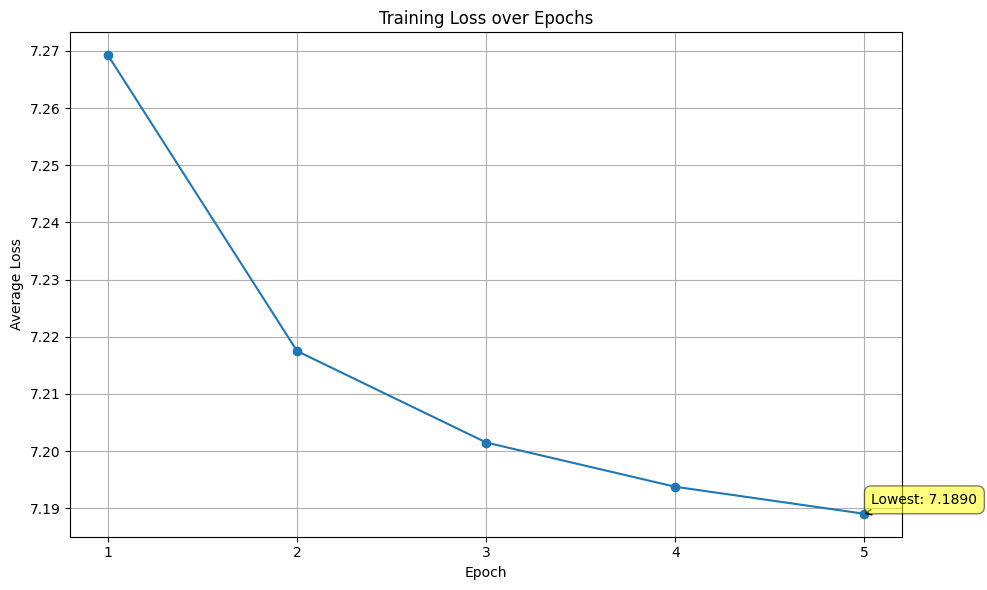

In [47]:
import matplotlib.pyplot as plt


def plot_loss_history(loss_history, num_epochs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), loss_history, marker="o")
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.xticks(range(1, num_epochs + 1))  # Set x-axis ticks to show each epoch

    # Annotate the lowest loss point
    min_loss = min(loss_history)
    min_epoch = loss_history.index(min_loss) + 1
    plt.annotate(
        f"Lowest: {min_loss:.4f}",
        xy=(min_epoch, min_loss),
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.5),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
    )

    plt.tight_layout()
    plt.show()


plot_loss_history(loss_history, num_epochs)

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

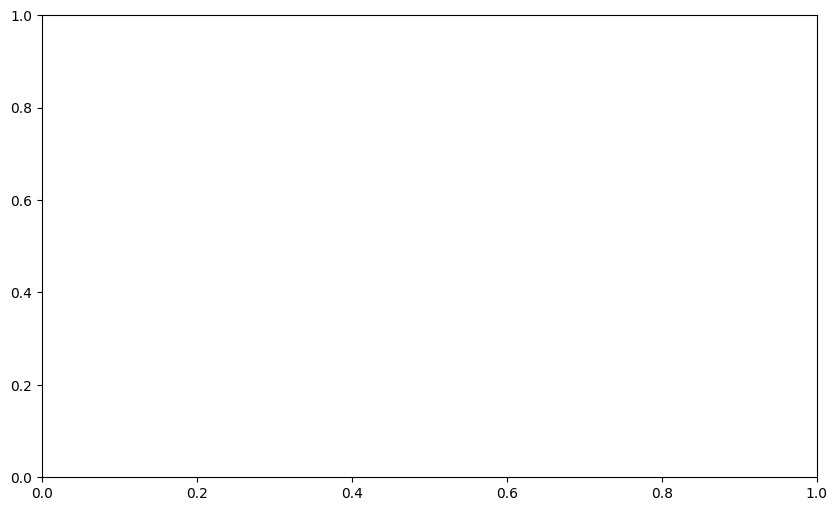

In [48]:
plot_loss_history(reg_loss_history, num_epochs)